## Pricing a European Call Option under Risk Neutrality

#### Author: [John Stachurski](http://johnstachurski.net/)
#### Date: Nov 2022

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from dataclasses import dataclass, astuple

We are going to price a European call option under the assumption of risk neutrality.  The price satisfies


$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

where

1. $\beta$ is a discount factor,
2. $n$ is the expiry date,
2. $K$ is the strike price and
3. $\{S_t\}$ is the price of the underlying asset at each time $t$.

(For example, if the call option is to buy stock in Amazon at strike price $K$, the owner has the right to buy 1 share in Amazon at price $K$ after $n$ days.  The price is the expectation of the return $\max\{S_n - K, 0\}$, discounted to current value.)

## Lognormal Example

Let's start with an easy case where $S_n$ has a known distribution.

Suppose in particular that $S_n$ has the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution with parameters $\mu$ and $\sigma$.  Let $f$ denote the density of this distribution.  Then

$$ P = \beta^n \int_0^\infty \max\{x - K, 0\} f(x) dx $$

Let's first plot the function 

$$g(x) = \beta^n  \max\{x - K, 0\} f(x)$$ 

over the interval $[0, 400]$ when

In [2]:
μ, σ, β, n, K = 4, 0.25, 0.99, 10, 40

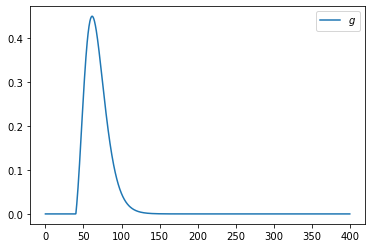

In [3]:
from scipy.integrate import quad
from scipy.stats import lognorm

def g(x):
    return β**n * np.maximum(x - K, 0) * lognorm.pdf(x, σ, scale=np.exp(μ))

x_grid = np.linspace(0, 400, 1000)
y_grid = g(x_grid) 

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()

### Integration with Quadrature

We can integrate numerically using quadrature to obtain the price:

In [4]:
P, error = quad(g, 0, 1_000)
print(f"The numerical integration based option price is {P:3f}")

The numerical integration based option price is 15.188161


### Integration via Monte Carlo

We can get a similar result using Monte Carlo to compute the expectation term in the option price, rather than `quad`.

We use the fact that if $S_n^1, \ldots, S_n^M$ are independent draws from the lognormal distribution specified above, then, by the law of large numbers,

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
  

In [5]:
M = 10_000_000
S = np.exp(μ + σ * np.random.randn(M))
return_draws = np.maximum(S - K, 0)
P = β**n * np.mean(return_draws) 
print(f"The Monte Carlo option price is {P:3f}")

The Monte Carlo option price is 15.188883


## A Model with Stochastic Volatility

In the last example we had a known distribution for $S_n$.

Now let's investigate a more realistic model, where we begin by specifying the underlying dynamics.

One common model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal.  However, its predictions are counterfactual because volatility is not stationary but rather changes over time.  

Here is an improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.

### Visualizing Paths

Let's write a function that simulates the sequence $S_0, \ldots, S_n$, where the parameters are set to

In [6]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0
n  = 20

(Here `S0` is $S_0$ and `h0` is $h_0$.)

We plot 50 paths of the form $S_0, \ldots, S_n$.

With $s_t := \ln S_t$, the price dynamics become

$$ s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1} $$

Here is a function to simulate a path using this equation:

In [7]:
from numpy.random import randn

def simulate_asset_price_path(μ=μ, S0=S0, h0=h0, n=n, ρ=ρ, ν=ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

Here we plot the paths and the log of the paths.

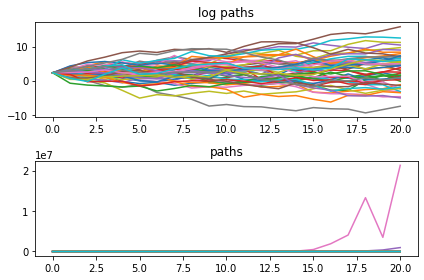

In [8]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)
    
fig.tight_layout()
plt.show()

### Monte Carlo Computation via Numba

Now we compute the price of the option $P_0$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
    


In [9]:
from numba import njit

In [43]:
@dataclass
class Params:
    """
    A class that stores parameter values and initial conditions.
    """
    
    β: float = 0.95
    μ: float = 0.0001
    K: float = 100.0
    n: int = 10
    ρ: float = 0.1
    ν: float = 0.001
    S0: float = 10.0
    h0: float = 0.0

    def __iter__(self):
        yield from astuple(self)


In [54]:
# A namedtuple definition for storing parameters and initial conditions
Model = namedtuple("Model", 
                   ("β", "μ", "K", "n", "ρ", "ν", "S0", "h0"))

In [55]:
def create_model(β=0.95,
                    μ=0.0001,
                    K=100,
                    n=10,
                    ρ=0.1,
                    ν=0.001,
                    S0=10,
                    h0=0):

    return Model(β=β, μ=μ, K=K, n=n, ρ=ρ, ν=ν, S0=S0, h0=h0)

In [56]:
default_model = create_model()
default_M=10_000_000

In [57]:
@njit
def compute_call_price(model=default_model, M=default_M):

    β, μ, K, n, ρ, ν, S0, h0 = model

    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [58]:
%%time 
compute_call_price()

CPU times: user 3.97 s, sys: 11.5 ms, total: 3.98 s
Wall time: 3.96 s


894.0890036123989

### Acceleration via `prange`

Let's use `prange` from Numba to parallelize this code on the CPU and make it faster.

In [59]:
from numba import prange

In [73]:
@njit(parallel=True)
def compute_call_price_parallel(model=default_model, M=default_M):

    β, μ, K, n, ρ, ν, S0, h0 = model

    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

NameError: name 'default_model' is not defined

In [61]:
%%time
compute_call_price_parallel()

CPU times: user 8.52 s, sys: 0 ns, total: 8.52 s
Wall time: 1.41 s


852.697829152791

In [62]:
%%time
compute_call_price_parallel()

CPU times: user 8.24 s, sys: 7 ms, total: 8.25 s
Wall time: 1.08 s


936.8689230471717

### A GPU Implementation Using CUDA

In [68]:
from math import log, exp
from numba import cuda, objmode
from numba.cuda.random import xoroshiro128p_normal_float32 as xnf32
from numba.cuda.random import create_xoroshiro128p_states as x128_states

In [69]:
@cuda.jit(device=True)
def update_price(params, s, h, ξ_1, ξ_2):
    "Update the state"
    β, μ, K, n, ρ, ν = params
    s = s + μ + exp(h) * ξ_1
    h = ρ * h + ν * ξ_2
    return s, h

In [74]:
@cuda.jit
def price_generation_kernel(params, init_vals, price_sample, rng_states):
    """
    Kernel function for the GPU.
    Produces one observation of S_n, using the D-MCE algorithm.
    """

    # Get position and unpack parameter values
    pos = cuda.grid(1)
    β, μ, K, n, ρ, ν = params
    S0, h0 = init_vals
    
    s, h = log(S0), h0
    for t in range(n):

        # Update price
        ξ_1 = xnf32(rng_states, pos)
        ξ_2 = xnf32(rng_states, pos)

        s, h = update_price(params, s, h, ξ_1, ξ_2)

    price_sample[pos] = exp(s)

In [75]:
def compute_call_price_cuda(params,
                            M=default_M,
                            seed=1234, 
                            threads_per_block=64):
    """
    This function launches the kernel and returns an 
    a Monte Carlo estimate of the price
    """
    # Set up
    nthreads = threads_per_block
    nblocks = M // nthreads
    β, μ, K, n, ρ, ν, S0, h0 = params

    # Generate the random states
    rng_states = x128_states(n, seed=seed)

    # Allocate memory -- TODO put this on the device
    price_sample = np.zeros(M)

    price_generation_kernel[nblocks, nthreads](params, price_sample, rng_states)

    payoffs = np.maximum(np.exp(price_sample) - K, 0)
    return β**n * np.mean(payoffs)

In [76]:
%%time
compute_call_price_cuda(params=default_params)

CudaAPIError: [700] Call to cuMemAlloc results in UNKNOWN_CUDA_ERROR